# Introduction

This project aims to be able to classify input images as HDR or SDR. To these ends, we employ a multitude of methods of doing so, from PCA analysis to Neural Networks. To add depth to our investigation, we also decided to involve julia set fractals generated based on the contrast of an image.

## HDR Explained

HDR images display greater detail and a wider range of colors compared to SDR. The primary difference is the dynamic range being the information range between dark and light regions of the image. HDR images calculate the amount of light in an image and use this information to normalize the brightness preventing some colors from being removed.

## Fractals Explained

Essentially, they are a way to generate infinite images. The basic concept is to take a complex number, perform a function on that number (Z^2+C) then use the output as the new input (known as an orbit). We can classify every complex number in the plane based on if the number converges or diverges through the iterations. It turns out if Z^2+C is ever greater than 2 the number will diverge, otherwise it converges. If the complex number converges we paint it black (or any color you want), otherwise you paint it proportional to how many iterations it made it through before its length was greater than 2. Chaotic spirals emerge on the borders essentially because, based on the fact that there is an infinite amount of numbers between any two numbers, if you take an complex number on the border inside the set and add some infinitesimal step, it’s basically impossible to tell if that neighbor will be inside or outside the set.  

# Data Collection and Preparation

The data for this project comes from [this website](ftp://lesc.dinfo.unifi.it/pub/Public/HDR/). It is a database of images of different subjects in both HDR and SDR that was used for a different research project but has since been released out to the public. The data was downloaded using the following script.

In [11]:
# Note that this script will not run unless the wget package is installed and the correct folder structure is present.
import wget
		
devices = ['A01_GioneeS55', 'A02_Huawei-P8', 'A03_Huawei-P9', 'A04_Huawei-P10', 'A05_Hwawie-MatePro10', 'A06_Huawei-Y5', 'A07_Galaxy-S7', 'A08_Galaxy-S7', 'A09_Galaxy-Note5', 'A10_Galaxy-J7', 'A11_Xiaomi5', 'A12_Huawei-RY6', 'A13_Huawei-RY6', 'A14_Xiaomi-5A', 'A15_Xiaom-3', 'A16_OnePlus-3t', 'A17_AsusZenfone-2', 'I03_iPhone7', 'I04_iPad-Air', 'I06_iPhone-5S']

category = "HDR"
for device in devices[-1:]:
    number = 1
    while True:
        try:
            link = 'ftp://lesc.dinfo.unifi.it/pub/Public/HDR/{}/NAT/{}_TRIPOD/{}_{}_TRIPOD_{:03}.jpg'.format(device, category, device[:3], category, number)
            wget.download(link, out=f"{device}/{category}-{number}.jpg")
            number += 1
        except Exception as thing:
            print(f"Exception Occurred at : {category}-{number}")
            if category == "HDR":
                category = "SDR"
                number = 1
            else:
                break
    
     

The below is an example of an HDR image and its SDR counterpart.

Text(0.5, 1.0, 'A01_GioneeS55\\SDR-1.jpg')

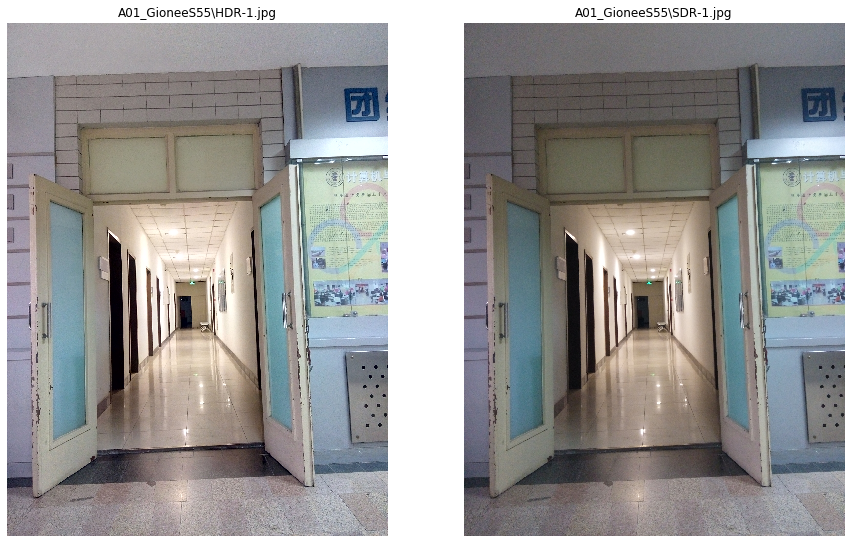

In [18]:
from PIL import Image

image_datas = [Image.open("A01_GioneeS55\HDR-1.jpg"), Image.open("A01_GioneeS55\SDR-1.jpg")]

f, axarr = plt.subplots(1,2, figsize = (15, 20))
axarr[0].imshow(image_datas[0])
axarr[0].axis('off')
axarr[0].set_title('A01_GioneeS55\HDR-1.jpg')
axarr[1].imshow(image_datas[1])
axarr[1].axis('off')
axarr[1].set_title('A01_GioneeS55\SDR-1.jpg')

The next step was to formulate an algorithm to generate fractals out of all of the downloaded images. The first step towards these ends was identifying a paramter to base the fractals on and formulate a way to measure said parameter. The results of this endeavor are below.

In [37]:
from PIL import Image
import numpy as np

# Print iterations progress
# Taken from https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

# Taken from https://stackoverflow.com/questions/9733288/how-to-programmatically-calculate-the-contrast-ratio-between-two-colors
# Translated into python by ourselves.
def luminanace(r, g, b):
    a = [r, g, b]
    for i in range(len(a)):
        color = a[i]
        color /= 255
        if color <= 0.03928:
            a[i] = color / 12.92
        else:
            a[i] = ((color + 0.055) / 1.055)**2.4
    
    return a[0] * 0.2126 + a[1] * 0.7152 + a[2] * 0.0722

def contrast(rgb1, rgb2): 
    result = (luminanace(rgb1[0], rgb1[1], rgb1[2]) + 0.05) / (luminanace(rgb2[0], rgb2[1], rgb2[2]) + 0.05)
    
    # Ensuring the order of parameters does not change the result.
    if result < 1: 
        result = 1/result
    
    return result


def calculate_average_contrast_with_other_pixels(im, pixel):
    contrasts = []
    for row in range(im.shape[0]): 
        for column in range(im.shape[1]):
            contrasts.append(contrast(pixel, im[row][column]))
    return np.mean(contrasts)


# This is the function that calculates the average contrast between the pixels of an image.
# Essentially, the function iterates through every pixel in the image and for each pixel, calculates
# the contrast between it and every other pixel in the image. The latter step is encapsulated in the above
# function which makes use of the contrast function, which in turn makes use of the functions for calculating 
# contrast and luminance. 
def image_contrast(path):
    im = np.asarray(Image.open(path).resize((30, 30)))
    avg_contrasts = []
    for row in range(im.shape[0]): 
        for column in range(im.shape[1]):
            avg_contrasts.append(calculate_average_contrast_with_other_pixels(im, im[row][column]))
            printProgressBar(row*im.shape[0]+column+1, im.shape[0]*im.shape[1])
    return np.mean(avg_contrasts), np.var(avg_contrasts)

Finally using the above, we could generate fractals using the following code.

In [40]:
import numpy as np
from scipy import misc
import imageio
import matplotlib.pyplot as plt
import os
from contrast_measurer import image_contrast
import json
 

# Function that generates julia set fractal given initial parameters.
# Adapted from: https://tomroelandts.com/articles/how-to-compute-colorful-fractals-using-numpy-and-matplotlib
def julia(output, m = 480, n = 320, s = 300, a = -0.4, b = 0.5, grayscale = False):
    x = np.linspace(-m / s, m / s, num=m).reshape((1, m))
    y = np.linspace(-n / s, n / s, num=n).reshape((n, 1))
    Z = np.tile(x, (n, 1)) + 1j * np.tile(y, (1, m))
    
    C = np.full((n, m), complex(a, b))
    M = np.full((n, m), True, dtype=bool)
    N = np.zeros((n, m))
    for i in range(256):
        Z[M] = Z[M] * Z[M] + C[M]
        M[np.abs(Z) > 2] = False
        N[M] = i
    
    if grayscale:
        # imageio.imwrite(output, np.flipud(1 - M))
        # This is the grayscale version.
        imageio.imwrite(output, np.flipud(255 - N))
        
    
    else:
        # Save with Matplotlib using a colormap.
        # This is the color version
        fig = plt.figure()
        fig.set_size_inches(m / 100, n / 100)
        ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(np.flipud(N))
        plt.savefig(f'.{output}')
        plt.close()

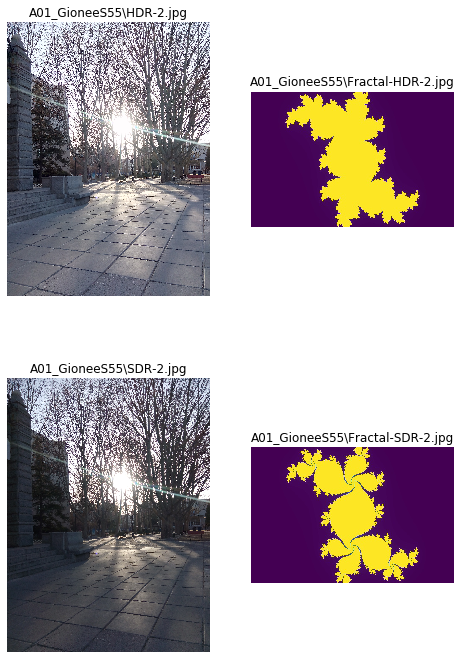

In [22]:
image_datas = [Image.open("A01_GioneeS55\HDR-2.jpg"), Image.open("A01_GioneeS55\Fractal-HDR-2.jpg"), Image.open("A01_GioneeS55\SDR-2.jpg"), Image.open("A01_GioneeS55\Fractal-SDR-2.jpg")]

f, axarr = plt.subplots(2,2, figsize = (8, 12))

for i in range(2):
    for j in range(2):
        axarr[i, j].imshow(image_datas[i*2+j])
        axarr[i, j].axis('off')
        axarr[i, j].set_title(image_datas[i*2+j].filename)

With all this done, we proceeded to use the data we generated to attempt to train machine learning models.

# Training

## PCA

## Convolutional Neural Networks

Our decision to investigate neural networks as a potential solution was due to their dominant prevalence in difficult to algorithmically define problems such as these. Our investigation led to us using a specific type of neural network - the convolutional neural network (CNN) - due to its particular effectivenes in image classfication problems. CNNs are similar to basic neural networks, with the difference lying in the use of filters as parts of the layers.

### Transfer Learning 
Code adapted from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

Even within CNNs, there were multiple ways to go about the process. One such method was transfer learning. This method essentially involves using a model that has already been pre trained on a large dataset and 'repurposing' it by training it
on the new data. Doing so is supposed to enhance effectiveness.

#### Without Fractals

In [15]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

torch.multiprocessing.freeze_support()
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data__dir'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=4)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.savefig("thing.jpg")  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=24)
visualize_model(model_ft)

In [29]:
# Logs for the last few epochs
# Epoch 20/23
# ----------
# train Loss: 0.6365 Acc: 0.6323
# val Loss: 0.8214 Acc: 0.4528

# Epoch 21/23
# ----------
# train Loss: 0.6503 Acc: 0.6355
# val Loss: 0.8193 Acc: 0.4245

# Epoch 22/23
# ----------
# train Loss: 0.6511 Acc: 0.6226
# val Loss: 0.8228 Acc: 0.3962

# Epoch 23/23
# ----------
# train Loss: 0.6693 Acc: 0.5871
# val Loss: 0.8198 Acc: 0.4151

# Training complete in 7m 4s
# Best val Acc: 0.500000

The model had accuracy exactly 50%. The following is some of the classifications made by the final model.

<img src="transferlearningwithout.jpg" alt="Drawing" style="width: 640px; height:480px"/> 

#### With Fractals

In [ ]:
data_dir = 'data__dir_fractal'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=4)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=24)
visualize_model(model_ft)

In [31]:
# Logs for the last few epochs
# Epoch 20/23
# ----------
# train Loss: 0.6909 Acc: 0.5629
# val Loss: 0.7062 Acc: 0.5175

# Epoch 21/23
# ----------
# train Loss: 0.6734 Acc: 0.5695
# val Loss: 0.7168 Acc: 0.5000

# Epoch 22/23
# ----------
# train Loss: 0.6773 Acc: 0.5795
# val Loss: 0.7143 Acc: 0.5000

# Epoch 23/23
# ----------
# train Loss: 0.6881 Acc: 0.5695
# val Loss: 0.7289 Acc: 0.5263

# Training complete in 2m 56s
# Best val Acc: 0.561404

This time the model had a slightly better accuracy of 56%. The following are the results for the model trained with the fractals instead.

<img src="transferlearningwith.jpg" alt="Drawing" style="width: 640px; height:480px"/> 

### Binary Classifier
Code for this section adapted from: https://github.com/jayrodge/Binary-Image-Classifier-PyTorch/blob/master/Binary_face_classifier.ipynb

The second method of using CNNs was to not use transfer learning and create the network from scratch using the available data. Since our data is of only two classes, we decided to implement a binary classification CNN.

#### Without Fractals

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
test_size = 0.3
valid_size = 0.1

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

data = datasets.ImageFolder('data__dir_binary',transform=transform)

#For test
num_data = len(data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

#For Valid
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(data, sampler = test_sampler, batch_size=batch_size, 
    num_workers=1)
classes = [0,1]

for batch in valid_loader:
    print(batch[0].size())

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    plt.savefig("thing.jpg")

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

train_on_gpu = torch.cuda.is_available()
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

import torch.optim as optim

# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum= 0.9)

# number of epochs to train the model
n_epochs = 5 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

    # track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
i=1
# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue

    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
#     print(target)

    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [27]:
# Epoch: 1        Training Loss: 0.421299         Validation Loss: 0.041617
# Validation loss decreased (inf --> 0.041617).  Saving model ...
# Epoch: 2        Training Loss: 0.371931         Validation Loss: 0.037014
# Validation loss decreased (0.041617 --> 0.037014).  Saving model ...
# Epoch: 3        Training Loss: 0.369603         Validation Loss: 0.038283
# Epoch: 4        Training Loss: 0.359903         Validation Loss: 0.037351
# Epoch: 5        Training Loss: 0.349221         Validation Loss: 0.037590
# Test Loss: 0.195213

# Test Accuracy (Overall): 50% (48/96)

The accuracy of the model without fractals was 50%. Some of the classifications are shown below. 1 means that the image was classified as HDR and vice versa.

<img src="thing.jpg" alt="Drawing" style="width: 1000px; height:400px"/> 

#### With Fractals

In [ ]:
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
test_size = 0.3
valid_size = 0.1

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

data = datasets.ImageFolder('data__dir_binary_fractal',transform=transform)

#For test
num_data = len(data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

#For Valid
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(data, sampler = test_sampler, batch_size=batch_size, 
    num_workers=1)
classes = [0,1]

for batch in valid_loader:
    print(batch[0].size())

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    plt.savefig("thing.jpg")

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

train_on_gpu = torch.cuda.is_available()
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

import torch.optim as optim

# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum= 0.9)

# number of epochs to train the model
n_epochs = 5 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

    # track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
i=1
# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue

    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
#     print(target)

    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [28]:
# Epoch: 1        Training Loss: 0.401943         Validation Loss: 0.039427
# Validation loss decreased (inf --> 0.039427).  Saving model ...
# Epoch: 2        Training Loss: 0.392773         Validation Loss: 0.038636
# Validation loss decreased (0.039427 --> 0.038636).  Saving model ...
# Epoch: 3        Training Loss: 0.383426         Validation Loss: 0.041589
# Epoch: 4        Training Loss: 0.386041         Validation Loss: 0.039223
# Epoch: 5        Training Loss: 0.381064         Validation Loss: 0.038848
# Test Loss: 0.177392

# Test Accuracy (Overall): 53% (51/96)

The accuracy of the model with fractals was 53%. Here are some of the predictions.

<img src="thingwith.jpg" alt="Drawing" style="width: 1000px; height:400px"/> 

## Luminance Subtraction

Finally, we wanted to test one more method that was a much simpler problem statement. Essentially, given two images, if it is known that one of them is HDR and the other SDR, is it possible to predict which is which? To these ends, we surmised an algorithm that computes the a property we term as the luminance difference. Essentially, we iterated through all the images of both pixels simultaneously and for each pixel in one image, we computed the difference between its luminance and the luminance of the pixel in the same position in the other image. The function that does so is below.

In [38]:
def luminance_diff(path1, path2):
    im1 = np.asarray(Image.open(path1).resize((30, 30)))
    im2 = np.asarray(Image.open(path2).resize((30, 30)))
    contrasts = []
    for row in range(im1.shape[0]): 
        for column in range(im1.shape[1]):
            c1 = im1[row][column]
            c2 = im2[row][column]
            contrasts.append(luminanace(c1[0], c1[1], c1[2])-luminanace(c2[0], c2[1], c2[2]))
            printProgressBar(row*im1.shape[0]+column+1, im1.shape[0]*im1.shape[1])
    return np.mean(contrasts), np.var(contrasts)

The results of using the above function on our data is below.

Thus, if one were to use the luminance_diff value of one of the images 
being lower as a classifier, 56.16% accuracy could be obtained.


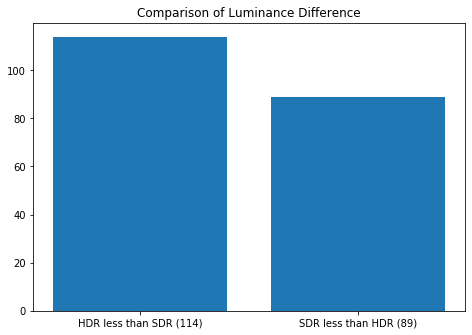

In [35]:
import matplotlib.pyplot as plt
import json

neg_count = 0
pos_count = 0
data = json.load(open("luminance_data.json"))
for item in data:
    for entry in data[item]:
        name, luminance_data = entry
        diff = luminance_data[0]
        if diff < 0:
            pos_count += 1
        else:
            neg_count += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = [f'HDR less than SDR ({pos_count})', f'SDR less than HDR ({neg_count})']
counts = [pos_count, neg_count]
plt.bar(labels,counts)
plt.title("Comparison of Luminance Difference")
percentage = pos_count/(pos_count+neg_count)*100
print(f'Thus, if one were to use the luminance_diff value of one of the images \nbeing lower as a classifier, {percentage:.2f}% accuracy could be obtained.')

# Conclusion

Unfortunately, our investigation did not lead to any meaningful results. Overall, it seemed the last method which needed to be given exactly two images which had to be of the same subject but different  HDR/SDR. Though, even this can barely be called better than the other methods used. One interesting fact which is likely a coincidence is that the CNN method using fractals was able to achieve accuracy of 56.14% in spite of the fact that it did not need any special conditions like the luminance_diff algorithm. Unfortunately, we did not have the technical expertise or time necessary to completely investigate why this was.

However, that is not to say that the project was fruitless. We all learned a great deal about fractals and creating and using Neural Networks using an industry standard tool. 

As far as things we would do differently next time, we would likely attempt to obtain more data and attempt our different methods once again. Furthermore, we would also likely to wish to experiment with other types of neural networks and models which could not be done due to the time constraints surrounding this project. 

Ultimately, we are satisfied with what we were able to accomplish given the circumstances.